# Hyper Parameter tuning using Grid Search

## Import

In [105]:
import os
import sys
import logging
import multiprocessing
import pandas as pd
import numpy as np
import sqlalchemy
import exchange_calendars as xcals
from dotenv import load_dotenv

# import exchange_calendars as xcals
from datetime import datetime, timedelta

# import pytz
# import pandas as pd
# from IPython.display import display, HTML
from sqlalchemy import create_engine, text
from sqlalchemy.dialects.postgresql import insert
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache

from neuralprophet import NeuralProphet, set_log_level, set_random_seed

# Disable logging messages unless there is an error
set_log_level("ERROR")

## Init

In [25]:
random_seed = 7

load_dotenv()  # take environment variables from .env.

module_path = os.getenv("LOCAL_AKSHARE_DEV_MODULE")
if module_path is not None and module_path not in sys.path:
    sys.path.insert(0, module_path)
import akshare as ak  # noqa: E402

print(ak.__version__)

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create an engine instance
alchemyEngine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_recycle=3600,
)

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

file_handler = logging.FileHandler("etl.log")
console_handler = logging.StreamHandler()

# Step 4: Create a formatter
formatter = logging.Formatter("%(name)s - %(levelname)s - %(message)s")

# Step 5: Attach the formatter to the handlers
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Step 6: Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

xshg = xcals.get_calendar("XSHG")

1.12.93


## Helper Functions

In [41]:
def train(df):
    set_random_seed(random_seed)
    m = NeuralProphet(
        weekly_seasonality=False,
        daily_seasonality=False,
        impute_missing=True,
    )
    covars = [col for col in df.columns if col not in ('ds', 'y')]
    m.add_lagged_regressor(covars)
    train_df, test_df = m.split_df(
        df,
        valid_p=1.0 / 10,
    )
    metrics = m.fit(
        train_df,
        validation_df=test_df,
        progress=None,
    )
    return metrics.tail()


## Anchor TS

In [44]:
# load anchor TS
symbol = "930955"
query = f"""
    SELECT date DS, change_rate y, vol_change_rate vol_cr, amt_change_rate amt_cr, 
        open, close, high, low, volume, amount
    FROM index_daily_em_view
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["ds"])

# Display the first few rows of the dataframe
df.head()

ds     y  vol_cr  amt_cr     open    close     high      low  \
0  2020-02-10  0.00    0.00    0.00  8164.40  8265.17  8269.77  8136.36   
1  2020-02-11  0.44    4.13   -3.13  8270.06  8301.47  8345.08  8243.03   
2  2020-02-12  0.42  -23.45  -24.09  8294.21  8336.28  8336.28  8266.64   
3  2020-02-13 -0.71    8.63   18.13  8329.26  8276.91  8368.77  8275.46   
4  2020-02-14  0.43   -5.38   -5.86  8264.24  8312.55  8321.35  8264.24   

     volume        amount  
0  339588.0  2.830927e+10  
1  353603.0  2.742411e+10  
2  270681.0  2.081825e+10  
3  294042.0  2.459196e+10  
4  278215.0  2.315006e+10

In [45]:
min_date = df['ds'].min().strftime("%Y-%m-%d")
# get a list of other China indices
query = f"""
    select distinct symbol 
    from index_daily_em_view 
    where symbol <> '{symbol}' and date <= '{min_date}'
"""
cov_symbols = pd.read_sql(query, alchemyEngine)
len(cov_symbols)

818

In [ ]:
# rank = pd.DataFrame()
# cov_symbol = cov_symbols['symbol'].iloc[0]

def load_train(symbol):
    query = f"""
        select date ds, change_rate y_{symbol}
        from index_daily_em_view 
        where symbol = '{symbol}'
        and date >= '{min_date}'
        order by date
    """
    cov_symbol_df = pd.read_sql(query, alchemyEngine)
    merged_df = pd.merge(df, cov_symbol_df, on='ds', how="left")
    output = train(merged_df)
    # extract the last row of output, add symbol column, and consolidate to another dataframe
    last_row = output.iloc[[-1]]
    last_row['symbol'] = symbol
    return last_row
    # rank = pd.concat([rank, last_row], ignore_index=True)

# get the number of CPU cores
num_proc = int((multiprocessing.cpu_count() + 1) / 2.0)

results = []
# Use ThreadPoolExecutor to calculate metrics in parallel
with ThreadPoolExecutor(max_workers=num_proc) as executor:
    futures = [
        executor.submit(load_train, symbol)
        for symbol in cov_symbols["symbol"]
    ]
    for f in futures:
        try:
            results.append(f.result())
        except Exception as e:
            print(e)
    # results = [future.result() for future in futures]

In [54]:
# results = []
# for f in futures:
#     try:
#         results.append(f.result())
#     except Exception as e:
#         print(e)
# results = [future.result() for future in futures]

'pytorch_lightning.utilities.argparse_utils'
Dataframe column 'y_395001' only has NaN rows.
Dataframe column 'y_395002' only has NaN rows.
Dataframe column 'y_395011' only has NaN rows.
Dataframe column 'y_395012' only has NaN rows.
Dataframe column 'y_395013' only has NaN rows.
Dataframe column 'y_395041' only has NaN rows.
Dataframe column 'y_395099' only has NaN rows.
Inputs/targets with missing values detected. Please either adjust imputation parameters, or set 'drop_missing' to True to drop those samples.
'pytorch_lightning.utilities.argparse_utils'


In [58]:
results

[      MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch      MAE      RMSE  \
 119  0.582638  0.858642  0.027963          0.0    119  0.70209  0.930987   
 
          Loss  RegLoss  symbol  
 119  0.024924      0.0  000001  ,
      MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
 119   0.6185   0.88607  0.029783          0.0    119  0.724755  0.958793   
 
          Loss  RegLoss  symbol  
 119  0.025952      0.0  000002  ,
       MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
 119  0.873481  1.132213  0.048158          0.0    119  0.709102  0.937982   
 
          Loss  RegLoss  symbol  
 119  0.025245      0.0  000003  ,
       MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
 119  0.654259  0.932548  0.032975          0.0    119  0.694622  0.932583   
 
          Loss  RegLoss  symbol  
 119  0.024518      0.0  000004  ,
       MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE     RMSE  \
 119  0.583911  0.8

In [60]:
# The list `results` has the following values for example:
# [      MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch      MAE      RMSE  \
#  119  0.582638  0.858642  0.027963          0.0    119  0.70209  0.930987   
 
#           Loss  RegLoss  symbol  
#  119  0.024924      0.0  000001  ,
#       MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
#  119   0.6185   0.88607  0.029783          0.0    119  0.724755  0.958793   
 
#           Loss  RegLoss  symbol  
#  119  0.025952      0.0  000002  ,
#        MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
#  119  0.873481  1.132213  0.048158          0.0    119  0.709102  0.937982   
 
# convert list `results` to dataframe
results_pd = pd.concat(results)
# rank the records in results by `Loss_val`, ascending.
results_pd.sort_values(by='Loss_val', inplace=True)
# save results_pd to csv file
results_pd.to_csv('results.csv', index=False)

In [97]:
results_pd.head()

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
119  0.566852  0.835567  0.026500          0.0    119  0.714363  0.948688   
119  0.566933  0.835336  0.026512          0.0    119  0.702557  0.931395   
119  0.564157  0.834427  0.026552          0.0    119  0.744204  0.989520   
119  0.571664  0.834405  0.026560          0.0    119  0.723327  0.953772   
119  0.561849  0.834630  0.026569          0.0    119  0.722127  0.961931   

         Loss  RegLoss  symbol  
119  0.026062      0.0  000917  
119  0.024947      0.0  399107  
119  0.027880      0.0  399690  
119  0.025888      0.0  930719  
119  0.026030      0.0  399243

In [106]:
# save the results_pd to database table. The table has been created using the following DDL:
# CREATE TABLE neuralprophet_corel (
#     symbol TEXT NOT NULL,
#     cov_symbol TEXT NOT NULL,
#     feature TEXT NOT NULL,
#     mae_val NUMERIC,
#     rmse_val NUMERIC,
#     loss_val numeric,
#     PRIMARY KEY (symbol, cov_symbol, feature)
# );

# Insert data into the table
insert_query = """
    INSERT INTO neuralprophet_corel 
        (symbol, cov_symbol, feature, mae_val, rmse_val, loss_val) 
    VALUES (%s, %s, %s, %s, %s, %s) 
    ON CONFLICT (symbol, cov_symbol, feature) 
    DO UPDATE SET 
        mae_val = EXCLUDED.mae_val, 
        rmse_val = EXCLUDED.rmse_val, 
        loss_val = EXCLUDED.loss_val
"""

with alchemyEngine.begin() as conn:
    # Inserting DataFrame into the database table
    for index, row in results_pd.iterrows():
        conn.execute(
            text("""
                INSERT INTO neuralprophet_corel 
                (symbol, cov_symbol, feature, mae_val, rmse_val, loss_val) 
                VALUES (:symbol, :cov_symbol, :feature, :mae_val, :rmse_val, :loss_val) 
                ON CONFLICT (symbol, cov_symbol, feature) 
                DO UPDATE SET mae_val = EXCLUDED.mae_val, rmse_val = EXCLUDED.rmse_val, loss_val = EXCLUDED.loss_val
            """),
            {
                "symbol": symbol,
                "cov_symbol": row["symbol"],
                "feature": "change_rate",
                "mae_val": row["MAE_val"],
                "rmse_val": row["RMSE_val"],
                "loss_val": row["Loss_val"],
            },
        )

In [61]:
cov100 = results_pd.head(100)
cov100

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
119  0.566852  0.835567  0.026500          0.0    119  0.714363  0.948688   
119  0.566933  0.835336  0.026512          0.0    119  0.702557  0.931395   
119  0.564157  0.834427  0.026552          0.0    119  0.744204  0.989520   
119  0.571664  0.834405  0.026560          0.0    119  0.723327  0.953772   
119  0.561849  0.834630  0.026569          0.0    119  0.722127  0.961931   
..        ...       ...       ...          ...    ...       ...       ...   
119  0.580418  0.856362  0.027817          0.0    119  0.706161  0.935165   
119  0.578187  0.857110  0.027820          0.0    119  0.703979  0.933641   
119  0.581805  0.858153  0.027822          0.0    119  0.714768  0.956789   
119  0.576340  0.856857  0.027822          0.0    119  0.714365  0.944340   
119  0.582152  0.858521  0.027830          0.0    119  0.708856  0.937170   

         Loss  RegLoss  symbol  
119  0.026062      0.0  000917  
119  0.024947      0.0  399107  
119  0.027880      0.0  399690  
119  0.025888      0.0  930719  
119  0.026030      0.0  399243  
..        ...      ...     ...  
119  0.025045      0.0  H50006  
119  0.024977      0.0  000108  
119  0.025675      0.0  399108  
119  0.025489      0.0  H11081  
119  0.025197      0.0  000029  

[100 rows x 10 columns]

In [76]:
# query records from `fund_etc_daily_em` table, where the `symbol` column is in the cov100 dataframe's `symbol` column.
cov100_symbols = cov100['symbol'].tolist()
# param_names = [f":s{i}" for i in range(len(cov100_symbols))]
# in_clause = ",".join(param_names)
query = """
    SELECT symbol ID, date DS, change_rate y
    FROM index_daily_em_view 
    where symbol in %(symbols)s
    order by ID, DS asc
"""
# params = {f"s{i}": s_val for i, s_val in enumerate(cov100_symbols)}
params = {'symbols': tuple(cov100_symbols)}
# with alchemyEngine.connect() as conn:
    # result = pd.read_sql_query(query, conn, params=params)
    # cov100_daily_df = pd.read_sql_query(query, conn, params=params, parse_dates=["ds"])
cov100_daily_df = pd.read_sql(query, alchemyEngine, params=params, parse_dates=["ds"])
len(cov100_daily_df)

297909

In [77]:
cov100_daily_df.isna().any()

id    False
ds    False
y     False
dtype: bool

In [83]:
# show the data type of each column for df
df.dtypes

ds         object
y         float64
vol_cr    float64
amt_cr    float64
open      float64
close     float64
high      float64
low       float64
volume    float64
amount    float64
dtype: object

In [84]:
merged_df = df[['ds','y']]
# merged_df['ds'] = pd.to_datetime(merged_df['ds'])

# merge and append the 'change_rate' column of cov_df to df, by matching dates
# split cov_df by symbol column
grouped = cov100_daily_df.groupby("id")
# sub_dfs = {group: data for group, data in grouped}
for group, sdf in grouped:
    sdf = sdf.rename(
        columns={
            "y": f"y_{group}",
        }
    )
    sdf = sdf[['ds', f"y_{group}"]]
    merged_df = pd.merge(merged_df, sdf[["ds", f"y_{group}"]], on='ds', how="left")

merged_df.describe()

ds            y     y_000019     y_000026  \
count                        1003  1003.000000  1003.000000  1003.000000   
mean   2022-02-28 05:15:51.146560     0.032323     0.008744     0.073280   
min           2020-02-10 00:00:00    -4.850000    -5.770000    -5.790000   
25%           2021-02-18 12:00:00    -0.485000    -0.555000    -0.860000   
50%           2022-03-02 00:00:00     0.010000     0.010000     0.080000   
75%           2023-03-13 12:00:00     0.565000     0.575000     0.970000   
max           2024-03-25 00:00:00     6.560000     6.650000     7.530000   
std                           NaN     0.966437     1.059676     1.670987   

          y_000029     y_000032     y_000036     y_000037     y_000043  \
count  1003.000000  1003.000000  1003.000000  1003.000000  1003.000000   
mean     -0.000229     0.080189     0.027637    -0.007567    -0.015354   
min      -5.640000    -7.600000    -7.520000    -6.970000    -4.950000   
25%      -0.670000    -0.820000    -0.945000    -0.930000    -0.695000   
50%      -0.040000     0.020000    -0.020000    -0.030000    -0.010000   
75%       0.595000     0.940000     0.975000     0.975000     0.610000   
max       7.660000     6.290000     6.510000     7.730000     6.370000   
std       1.134847     1.737348     1.597555     1.630466     1.172392   

          y_000048  ...     y_H30039     y_H30053     y_H30064     y_H30344  \
count  1003.000000  ...  1003.000000  1003.000000  1003.000000  1003.000000   
mean     -0.007318  ...    -0.032213     0.028345     0.034756    -0.027597   
min      -5.890000  ...    -7.590000    -7.530000    -7.110000    -5.880000   
25%      -0.640000  ...    -0.740000    -0.820000    -0.940000    -0.720000   
50%      -0.050000  ...     0.020000     0.080000     0.020000    -0.020000   
75%       0.585000  ...     0.755000     0.930000     0.950000     0.770000   
max       7.080000  ...     6.200000     5.670000     6.870000     6.010000   
std       1.158092  ...     1.433231     1.519577     1.682188     1.241719   

          y_H30537     y_H50002     y_H50006     y_H50030     y_H50035  \
count  1003.000000  1003.000000  1003.000000  1003.000000  1003.000000   
mean     -0.010080     0.035793    -0.019153     0.045374    -0.008903   
min      -7.420000    -6.240000    -7.470000    -6.680000    -7.940000   
25%      -0.775000    -0.845000    -1.050000    -0.590000    -0.980000   
50%       0.050000     0.030000    -0.060000     0.010000     0.000000   
75%       0.870000     0.935000     1.010000     0.665000     0.970000   
max       5.890000     6.980000     8.100000     7.870000     5.580000   
std       1.424265     1.616189     1.778218     1.311946     1.617705   

          y_H50054  
count  1003.000000  
mean      0.000289  
min      -6.580000  
25%      -0.870000  
50%      -0.020000  
75%       0.990000  
max       5.800000  
std       1.537359  

[8 rows x 102 columns]

## Train with Top-100 covariates

### T100-Default

In [93]:
def train_with_covars(epochs=None, **kwargs):
    set_random_seed(random_seed)
    m = NeuralProphet(
        **kwargs
    )
    covars = [col for col in merged_df.columns if col not in ('ds', 'y')]
    m.add_lagged_regressor(covars)
    train_df, test_df = m.split_df(
        merged_df,
        valid_p=1.0 / 10,
    )
    return m.fit(
        train_df,
        validation_df=test_df,
        progress=None,
        epochs=epochs,
    )

In [ ]:
# baseline
train_with_covars(
    epochs=500, 
    weekly_seasonality=False,
    daily_seasonality=False,
    impute_missing=True,
)

### Grid Search

In [109]:
from sklearn.model_selection import ParameterGrid

# Define your hyperparameters grid
param_grid = {
    "n_lags": list(range(2, 11)),
    "yearly_seasonality": list(range(10, 21)),
    "ar_layers": [[i] * i for i in range(2, 9)],
    "lagged_reg_layers": [[i] * i for i in range(2, 9)],
}
grid = ParameterGrid(param_grid)
len(grid)

KeyboardInterrupt: 

Exception ignored in: Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "/Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/ipykernel/iostream.py", line 694, in write
    self._schedule_flush()
  File "/Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/ipykernel/iostream.py", line 590, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "/Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/ipykernel/iostream.py", line 267, in schedule
    self._event_pipe.send(b"")
  File "/Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/zmq/sugar/socket.py", line 696, in send
    return super().send(data, flags=flags, copy=copy, track=track)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "zmq/backend/cython/socket.pyx", line 742, in zmq.backend.cython.socket.Socket.send
  Fi

In [112]:
def grid_search(params):
    metrics = train_with_covars(
        epochs=500,
        n_lags=params["n_lags"],
        yearly_seasonality=params["yearly_seasonality"],
        ar_layers=params["ar_layers"],
        lagged_reg_layers=params["lagged_reg_layers"],
        weekly_seasonality=False,
        daily_seasonality=False,
        impute_missing=True,
    )
    # Evaluate the model
    # Here, we'll simply use the last validation loss as a proxy for performance. You might want to use a different metric.
    return params, metrics.iloc[-1]


# get the number of CPU cores
num_proc = int((multiprocessing.cpu_count()) / 1.2)

results = []
# Use ThreadPoolExecutor to calculate metrics in parallel
with ThreadPoolExecutor(max_workers=num_proc) as executor:
    futures = [executor.submit(grid_search, params) for params in grid]
    for f in futures:
        try:
            results.append(f.result())
        except Exception as e:
            print(e)


# Sort the results based on 'Loss_val'
sorted_results = sorted(results, key=lambda x: x[1]["Loss_val"])

# Print the top 10 results
for params, metrics in sorted_results[:10]:
    print(f"Params: {params}, Metrics: {metrics}")

3920

In [115]:
print(grid[0], hash(grid[0]))
# for p in grid:
    # print()
    # sort p (which is a dict) by its key string, and then stringify p (hash it so that the hash of dict with the same key and value pairs shall be identical.)
    # p_sorted = dict(sorted(p.items()))
    # p_hash = hash(frozenset(p_sorted.items()))
    # print(p_hash)
    

TypeError: unhashable type: 'dict'

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

# Multivariate Experiements

## Benchmark

### Close CR + Turnover CR

| Setup | MAE_val | RMSE_val | Loss_val | diff_mean | diff_std |
|-------|---------|----------|----------|-----------|----------|
|[Default](#default)|0.587409|0.873636|0.028510|-0.0037|0.961|
|[FT15,AR5,ARnet4x4](#ft15ar5arnet4x4)|0.544901|0.809492|0.024314|0.0233|0.91|
|[FT15,AR5,ARnet5x8](#ft15ar5arnet5x8)|0.544550|0.821479|0.025064|0.00335|0.912|
|[FT15,AR5,4x4,2x2](#ft15ar54x42x2)|0.532781|0.809360|0.024468|0.00663|0.925|
|[FT15,AR5,4x4,4x4](#ft15ar54x44x4)|0.541571|0.817784|0.024822|-0.0141|0.9203|

### Close CR + Volume CR

| Setup | MAE_val | RMSE_val | Loss_val | diff_mean | diff_std |
|-------|---------|----------|----------|-----------|----------|
|[Default](#default)|0.588967|0.875254|0.028560|-0.003|0.962|

### Close CR + Volume CR + Turnover CR

| Setup | MAE_val | RMSE_val | Loss_val | diff_mean | diff_std |
|-------|---------|----------|----------|-----------|----------|
|[Default](#default)|0.585862|0.872914|0.028530|0.00583|0.96|

### Bond

| Setup | MAE_val | RMSE_val | Loss_val | diff_mean | diff_std |
|-------|---------|----------|----------|-----------|----------|
|[Default](#bond---default)|0.547821|0.801297|0.023871|0.02|0.925|
|[2x2](#bond---2x2)|0.543448|0.803755|0.024142|0.0102|0.9152|
|[4x4](#bond---4x4)|0.551836|0.823901|0.025290|-0.0117|0.914|


## Import

In [1]:
import os
import sys
import logging
import multiprocessing
import pandas as pd
import numpy as np
import sqlalchemy
import exchange_calendars as xcals
from dotenv import load_dotenv

# import exchange_calendars as xcals
from datetime import datetime, timedelta

# import pytz
# import pandas as pd
# from IPython.display import display, HTML
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import insert, TEXT
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache

from neuralprophet import NeuralProphet, set_log_level, set_random_seed

# Disable logging messages unless there is an error
set_log_level("ERROR")

# from prophet.plot import (
#     plot_plotly,
#     plot_components_plotly,
#     add_changepoints_to_plot,
#     plot_yearly,
#     plot_seasonality_plotly,
# )

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## Init

In [2]:
random_seed = 7

load_dotenv()  # take environment variables from .env.

module_path = os.getenv("LOCAL_AKSHARE_DEV_MODULE")
if module_path is not None and module_path not in sys.path:
    sys.path.insert(0, module_path)
import akshare as ak  # noqa: E402

print(ak.__version__)

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create an engine instance
alchemyEngine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_recycle=3600,
)

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

file_handler = logging.FileHandler("etl.log")
console_handler = logging.StreamHandler()

# Step 4: Create a formatter
formatter = logging.Formatter("%(name)s - %(levelname)s - %(message)s")

# Step 5: Attach the formatter to the handlers
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Step 6: Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

xshg = xcals.get_calendar("XSHG")

1.12.93


## Helper Functions

In [3]:
def predict(
    symbol, y_column, country=None, fourier_terms="auto", show_uncertainty=False
) -> (NeuralProphet, pd.DataFrame, pd.DataFrame):  # type: ignore
    return predict_generic(
        "fund_etf_daily_em", symbol, y_column, country, fourier_terms, show_uncertainty
    )


def predict_generic(
    table,
    symbol,
    y_column,
    country=None,
    fourier_terms="auto",
    show_uncertainty=False,
) -> (NeuralProphet, pd.DataFrame, pd.DataFrame):  # type: ignore
    query = f"SELECT * FROM {table} where symbol = '{symbol}' order by date"
    df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

    df = df.rename(
        columns={
            "date": "ds",
            y_column: "y",
        }
    )

    m = NeuralProphet(
        mcmc_samples=300 if show_uncertainty else 0,
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=fourier_terms,
    )  # Prophet object can only be fit once. Instantiate a new object.
    if country is not None:
        m.add_country_holidays(country_name=country)
    m.fit(df)

    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)

    return (m, df, forecast)

## Trial 1 - Close CR + Turnover CR

#### load data from table

In [4]:
# load main TS
symbol = "930955"
query = f"""
    SELECT date DS, change_rate y, vol_change_rate vol_cr, amt_change_rate amt_cr, 
        open, close, high, low, volume, amount
    FROM index_daily_em_view
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

# Display the first few rows of the dataframe
df.head()

ds     y  vol_cr  amt_cr     open    close     high      low  \
0  2020-02-10  0.00    0.00    0.00  8164.40  8265.17  8269.77  8136.36   
1  2020-02-11  0.44    4.13   -3.13  8270.06  8301.47  8345.08  8243.03   
2  2020-02-12  0.42  -23.45  -24.09  8294.21  8336.28  8336.28  8266.64   
3  2020-02-13 -0.71    8.63   18.13  8329.26  8276.91  8368.77  8275.46   
4  2020-02-14  0.43   -5.38   -5.86  8264.24  8312.55  8321.35  8264.24   

     volume        amount  
0  339588.0  2.830927e+10  
1  353603.0  2.742411e+10  
2  270681.0  2.081825e+10  
3  294042.0  2.459196e+10  
4  278215.0  2.315006e+10

In [ ]:
df.describe()

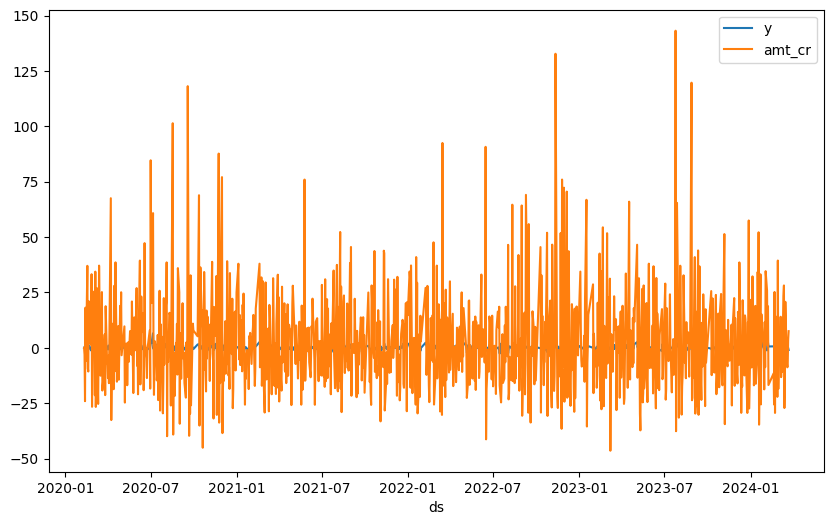

In [21]:
fig = df.plot(
    x="ds", y=["y", "amt_cr"], figsize=(10, 6)
)

In [ ]:
df = df[["ds", "y", "amt_cr"]]

In [38]:
# check if any nan value in df
df.isnull().any()

ds        False
y         False
amt_cr    False
dtype: bool

#### Default

In [23]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
)

m.add_lagged_regressor("amt_cr", n_lags="auto")

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((902, 3), (100, 3))

In [24]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
0    5.344194  6.396653  0.687497          0.0      0  4.142447  5.209342   
1    4.844329  5.845520  0.612754          0.0      1  3.418364  4.270522   
2    3.859893  4.678480  0.466744          0.0      2  2.751966  3.449415   
3    2.972880  3.584882  0.331255          0.0      3  2.310842  2.888974   
4    2.306597  2.748759  0.228825          0.0      4  1.819327  2.281063   
..        ...       ...       ...          ...    ...       ...       ...   
115  0.585655  0.872351  0.028458          0.0    115  0.726525  0.961002   
116  0.585241  0.872365  0.028471          0.0    116  0.727839  0.973662   
117  0.586002  0.872812  0.028477          0.0    117  0.705825  0.932307   
118  0.586118  0.872818  0.028480          0.0    118  0.717558  0.949951   
119  0.587409  0.873636  0.028510          0.0    119  0.722884  0.969601   

         Loss  RegLoss  
0    0.368287      0.0  
1    0.290749      0.0  
2    0.220815      0.0  
3    0.173142      0.0  
4    0.123009      0.0  
..        ...      ...  
115  0.026236      0.0  
116  0.026925      0.0  
117  0.025201      0.0  
118  0.025582      0.0  
119  0.026120      0.0  

[120 rows x 9 columns]

In [25]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])



In [26]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: -0.0036872191719718246, Standard deviation of difference: 0.9610769494162709


In [27]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



In [28]:
m.plot_components(
    forecast,
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:559: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [29]:
m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur

#### FT15,AR5,ARnet4x4

In [30]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
)

m.add_lagged_regressor("amt_cr", n_lags="auto")

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((968, 3), (112, 3))

In [31]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
0    8.703783  9.621788  1.189139          0.0      0  6.006469  7.228684   
1    5.917960  7.045305  0.769222          0.0      1  4.835095  5.958283   
2    3.912084  4.900574  0.465000          0.0      2  3.620685  4.569515   
3    3.190213  3.904958  0.357618          0.0      3  3.049596  3.841832   
4    2.871075  3.636992  0.311547          0.0      4  2.669212  3.348357   
..        ...       ...       ...          ...    ...       ...       ...   
105  0.548295  0.811097  0.024401          0.0    105  0.697785  0.908175   
106  0.547802  0.810678  0.024377          0.0    106  0.685837  0.894198   
107  0.547790  0.810822  0.024392          0.0    107  0.688769  0.898271   
108  0.548113  0.811008  0.024398          0.0    108  0.717175  0.930493   
109  0.544901  0.809492  0.024314          0.0    109  0.692546  0.900784   

         Loss  RegLoss  
0    0.618412      0.0  
1    0.476236      0.0  
2    0.327977      0.0  
3    0.258259      0.0  
4    0.215838      0.0  
..        ...      ...  
105  0.023452      0.0  
106  0.022980      0.0  
107  0.022977      0.0  
108  0.024923      0.0  
109  0.023160      0.0  

[110 rows x 9 columns]

In [32]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




In [33]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: 0.023343636004724236, Standard deviation of difference: 0.9103749251814985


In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



In [ ]:
m.plot_components(
    forecast,
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:559: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [ ]:
m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur

#### FT15,AR5,ARnet5x8

In [34]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[8] * 5,
)

m.add_lagged_regressor("amt_cr", n_lags="auto")

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((968, 3), (112, 3))

In [35]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
0    9.646489  10.841177  1.337297          0.0      0  5.816344  7.297796   
1    7.044925   8.205516  0.943882          0.0      1  4.172850  5.322094   
2    5.513389   6.544418  0.709115          0.0      2  3.292474  4.213471   
3    4.760166   5.658744  0.590305          0.0      3  2.864738  3.649198   
4    4.180367   4.972369  0.501221          0.0      4  2.606697  3.310323   
..        ...        ...       ...          ...    ...       ...       ...   
105  0.545672   0.823299  0.025138          0.0    105  0.694016  0.901157   
106  0.545159   0.822534  0.025106          0.0    106  0.684938  0.894442   
107  0.545171   0.822572  0.025099          0.0    107  0.684576  0.895938   
108  0.544307   0.821322  0.025050          0.0    108  0.686124  0.895143   
109  0.544550   0.821479  0.025064          0.0    109  0.747016  0.966276   

         Loss  RegLoss  
0    0.613066      0.0  
1    0.407715      0.0  
2    0.299518      0.0  
3    0.246814      0.0  
4    0.214108      0.0  
..        ...      ...  
105  0.023270      0.0  
106  0.023077      0.0  
107  0.022898      0.0  
108  0.022876      0.0  
109  0.026958      0.0  

[110 rows x 9 columns]

In [36]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




In [37]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: 0.003350843732602128, Standard deviation of difference: 0.9115405370646815


In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



In [ ]:
m.plot_components(
    forecast,
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:559: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [ ]:
m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur

#### FT15,AR5,4x4,2x2

In [45]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
    lagged_reg_layers=[2] * 2,
)

m.add_lagged_regressor("amt_cr", n_lags="auto")

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((968, 3), (112, 3))

In [46]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
0    3.383072  4.263128  0.387866          0.0      0  3.618841  4.424848   
1    2.839362  3.572156  0.310022          0.0      1  2.762105  3.432791   
2    1.633350  2.241521  0.145237          0.0      2  1.984082  2.487453   
3    1.896835  2.369551  0.169124          0.0      3  1.432988  1.807915   
4    1.032707  1.542594  0.072216          0.0      4  1.047462  1.346866   
..        ...       ...       ...          ...    ...       ...       ...   
105  0.532314  0.808809  0.024433          0.0    105  0.704533  0.920290   
106  0.531359  0.808352  0.024385          0.0    106  0.693611  0.911957   
107  0.531612  0.808131  0.024381          0.0    107  0.699663  0.920654   
108  0.532406  0.808942  0.024442          0.0    108  0.704735  0.925503   
109  0.532781  0.809360  0.024468          0.0    109  0.711429  0.927316   

         Loss  RegLoss  
0    0.319642      0.0  
1    0.218486      0.0  
2    0.138537      0.0  
3    0.083219      0.0  
4    0.049291      0.0  
..        ...      ...  
105  0.023918      0.0  
106  0.023457      0.0  
107  0.023740      0.0  
108  0.024182      0.0  
109  0.024199      0.0  

[110 rows x 9 columns]

In [47]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




In [48]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: 0.006630176758097708, Standard deviation of difference: 0.9248986974677772


In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



In [ ]:
m.plot_components(
    forecast,
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:559: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [ ]:
m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur

#### FT15,AR5,4x4,4x4

In [41]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
    lagged_reg_layers=[4] * 4,
)

m.add_lagged_regressor("amt_cr", n_lags="auto")

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((968, 3), (112, 3))

In [42]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
0    3.629030  4.613189  0.426898          0.0      0  3.722003  4.522390   
1    2.543553  3.313450  0.270997          0.0      1  2.786481  3.420995   
2    2.261714  2.818004  0.221527          0.0      2  2.046641  2.533051   
3    1.114625  1.624721  0.079250          0.0      3  1.422982  1.788762   
4    1.329146  1.702556  0.094774          0.0      4  1.057487  1.348915   
..        ...       ...       ...          ...    ...       ...       ...   
105  0.542637  0.817793  0.024910          0.0    105  0.691687  0.910566   
106  0.542041  0.817367  0.024868          0.0    106  0.682489  0.897125   
107  0.541594  0.817296  0.024852          0.0    107  0.693525  0.914361   
108  0.540945  0.817559  0.024849          0.0    108  0.696579  0.917708   
109  0.541571  0.817784  0.024822          0.0    109  0.685639  0.913117   

         Loss  RegLoss  
0    0.337392      0.0  
1    0.219637      0.0  
2    0.144334      0.0  
3    0.079703      0.0  
4    0.049919      0.0  
..        ...      ...  
105  0.023333      0.0  
106  0.023093      0.0  
107  0.023343      0.0  
108  0.024024      0.0  
109  0.023277      0.0  

[110 rows x 9 columns]

In [43]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




In [44]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: -0.014139063273634869, Standard deviation of difference: 0.9203225455706585


In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



In [ ]:
m.plot_components(
    forecast,
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:559: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [ ]:
m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur

## Trial 2: Close CR + Vol CR

#### load data from table

In [49]:
# load main TS
symbol = "930955"
query = f"""
    SELECT date DS, change_rate y, vol_change_rate vol_cr, amt_change_rate amt_cr, 
        open, close, high, low, volume, amount
    FROM index_daily_em_view
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

# Display the first few rows of the dataframe
df.head()

ds     y  vol_cr  amt_cr     open    close     high      low  \
0  2020-02-10  0.00    0.00    0.00  8164.40  8265.17  8269.77  8136.36   
1  2020-02-11  0.44    4.13   -3.13  8270.06  8301.47  8345.08  8243.03   
2  2020-02-12  0.42  -23.45  -24.09  8294.21  8336.28  8336.28  8266.64   
3  2020-02-13 -0.71    8.63   18.13  8329.26  8276.91  8368.77  8275.46   
4  2020-02-14  0.43   -5.38   -5.86  8264.24  8312.55  8321.35  8264.24   

     volume        amount  
0  339588.0  2.830927e+10  
1  353603.0  2.742411e+10  
2  270681.0  2.081825e+10  
3  294042.0  2.459196e+10  
4  278215.0  2.315006e+10

In [ ]:
df.describe()

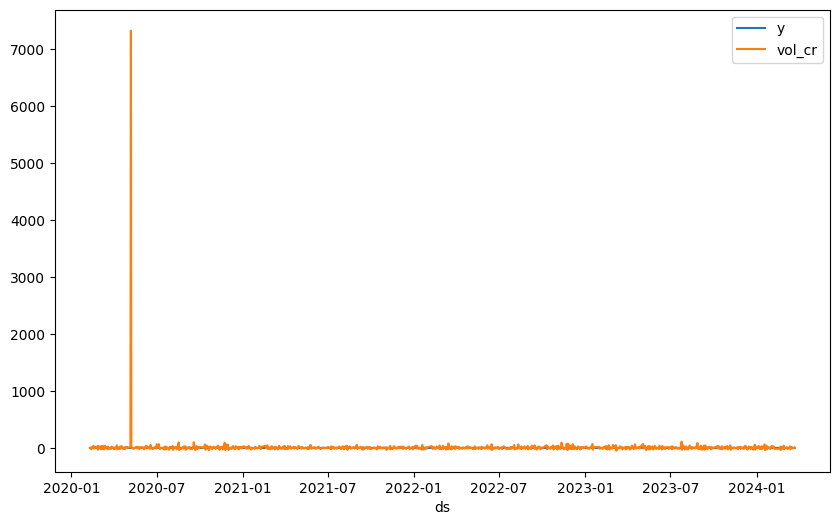

In [50]:
fig = df.plot(
    x="ds", y=["y", "vol_cr"], figsize=(10, 6)
)

In [51]:
df = df[["ds", "y", "vol_cr"]]

In [52]:
# check if any nan value in df
df.isnull().any()

ds        False
y         False
vol_cr    False
dtype: bool

#### Default

In [54]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
)

m.add_lagged_regressor(["vol_cr"])

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((902, 3), (100, 3))

In [55]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
0    5.377485  6.428301  0.691787          0.0      0  4.833229  8.854389   
1    4.934068  5.938103  0.624856          0.0      1  4.150755  7.903260   
2    4.063348  4.913893  0.497125          0.0      2  3.499383  7.019287   
3    3.273973  3.937055  0.376563          0.0      3  3.054936  6.358500   
4    2.617537  3.106415  0.273787          0.0      4  2.553418  5.582459   
..        ...       ...       ...          ...    ...       ...       ...   
115  0.586820  0.873889  0.028499          0.0    115  0.726343  0.962265   
116  0.587420  0.874005  0.028512          0.0    116  0.726942  0.974224   
117  0.588274  0.874513  0.028528          0.0    117  0.705765  0.933650   
118  0.588393  0.874555  0.028533          0.0    118  0.716595  0.950642   
119  0.588967  0.875254  0.028560          0.0    119  0.722185  0.970249   

         Loss  RegLoss  
0    0.420647      0.0  
1    0.348055      0.0  
2    0.280348      0.0  
3    0.233589      0.0  
4    0.183306      0.0  
..        ...      ...  
115  0.026274      0.0  
116  0.026929      0.0  
117  0.025223      0.0  
118  0.025591      0.0  
119  0.026129      0.0  

[120 rows x 9 columns]

In [56]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




In [57]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: -0.0030570214659303057, Standard deviation of difference: 0.9620024833197769


In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



In [ ]:
m.plot_components(
    forecast,
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:559: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [ ]:
m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur

## Trial 3: Close CR + Vol CR + Turnover CR

#### load data from table

In [58]:
# load main TS
symbol = "930955"
query = f"""
    SELECT date DS, change_rate y, vol_change_rate vol_cr, amt_change_rate amt_cr, 
        open, close, high, low, volume, amount
    FROM index_daily_em_view
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

# Display the first few rows of the dataframe
df.head()

ds     y  vol_cr  amt_cr     open    close     high      low  \
0  2020-02-10  0.00    0.00    0.00  8164.40  8265.17  8269.77  8136.36   
1  2020-02-11  0.44    4.13   -3.13  8270.06  8301.47  8345.08  8243.03   
2  2020-02-12  0.42  -23.45  -24.09  8294.21  8336.28  8336.28  8266.64   
3  2020-02-13 -0.71    8.63   18.13  8329.26  8276.91  8368.77  8275.46   
4  2020-02-14  0.43   -5.38   -5.86  8264.24  8312.55  8321.35  8264.24   

     volume        amount  
0  339588.0  2.830927e+10  
1  353603.0  2.742411e+10  
2  270681.0  2.081825e+10  
3  294042.0  2.459196e+10  
4  278215.0  2.315006e+10

In [ ]:
df.describe()

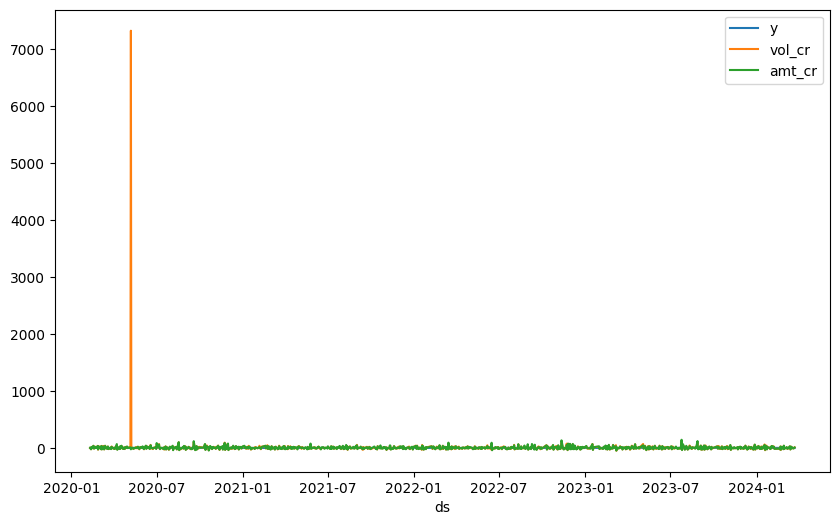

In [59]:
fig = df.plot(
    x="ds", y=["y", "vol_cr", "amt_cr"], figsize=(10, 6)
)

In [60]:
df = df[["ds", "y", "vol_cr", "amt_cr"]]

In [61]:
# check if any nan value in df
df.isnull().any()

ds        False
y         False
vol_cr    False
amt_cr    False
dtype: bool

#### Default

In [62]:
set_random_seed(random_seed)

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
)

m.add_lagged_regressor(["vol_cr", "amt_cr"])

train_df, test_df = m.split_df(
    df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((902, 4), (100, 4))

In [63]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
0    6.802483  8.168036  0.914438          0.0      0  4.329659  6.425880   
1    5.040925  6.267774  0.643856          0.0      1  3.366198  5.212960   
2    3.757042  4.788993  0.449971          0.0      2  2.841811  4.403121   
3    2.984670  3.758894  0.337637          0.0      3  2.297715  3.719248   
4    2.290883  2.747299  0.228646          0.0      4  1.840402  3.157652   
..        ...       ...       ...          ...    ...       ...       ...   
115  0.586224  0.872975  0.028541          0.0    115  0.746052  0.995164   
116  0.586490  0.872264  0.028501          0.0    116  0.707675  0.943508   
117  0.585578  0.872755  0.028536          0.0    117  0.707216  0.941692   
118  0.585349  0.872278  0.028502          0.0    118  0.720942  0.953452   
119  0.585862  0.872914  0.028530          0.0    119  0.706024  0.941568   

         Loss  RegLoss  
0    0.402684      0.0  
1    0.288022      0.0  
2    0.220595      0.0  
3    0.161658      0.0  
4    0.116579      0.0  
..        ...      ...  
115  0.028642      0.0  
116  0.025528      0.0  
117  0.025421      0.0  
118  0.026037      0.0  
119  0.025327      0.0  

[120 rows x 9 columns]

In [64]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




In [65]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: 0.005830651530019057, Standard deviation of difference: 0.9609098481407585


In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



In [ ]:
m.plot_components(
    forecast,
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:559: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [ ]:
m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur

## Trial X - Include More Time Series

#### load data from database

In [4]:
# load main TS
symbol = "930955"
query = f"""
    SELECT date DS, change_rate y, vol_change_rate vol_cr, amt_change_rate amt_cr, 
        open, close, high, low, volume, amount
    FROM index_daily_em_view
    where symbol='{symbol}'
    order by DS
"""
df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

# Display the first few rows of the dataframe
df.head()

# 159981 能源化工ETF
# 518880 黄金ETF
# 159985 豆粕ETF
# 511220 城投债ETF
cov_symbol_list = "('518880', '159981', '159985', '511220')"
query = f"""
    SELECT symbol, date DS, change_rate y 
    FROM fund_etf_daily_em 
    where symbol in {cov_symbol_list}
    order by DS asc
"""
cov_df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

In [5]:
# merge and append the 'change_rate' column of cov_df to df, by matching dates
# split cov_df by symbol column
grouped = cov_df.groupby("symbol")
# sub_dfs = {group: data for group, data in grouped}

for group, sdf in grouped:
    sdf = sdf.rename(
        columns={
            "y": f"{group}_y",
        }
    )
    df = pd.merge(df, sdf[["ds", f"{group}_y"]], on='ds', how="left")

df.head()

ds     y  vol_cr  amt_cr     open    close     high      low  \
0  2020-02-10  0.00    0.00    0.00  8164.40  8265.17  8269.77  8136.36   
1  2020-02-11  0.44    4.13   -3.13  8270.06  8301.47  8345.08  8243.03   
2  2020-02-12  0.42  -23.45  -24.09  8294.21  8336.28  8336.28  8266.64   
3  2020-02-13 -0.71    8.63   18.13  8329.26  8276.91  8368.77  8275.46   
4  2020-02-14  0.43   -5.38   -5.86  8264.24  8312.55  8321.35  8264.24   

     volume        amount  159981_y  159985_y  511220_y  518880_y  
0  339588.0  2.830927e+10     -0.53      1.06      0.09      0.37  
1  353603.0  2.742411e+10     -0.11     -0.21      0.12     -0.26  
2  270681.0  2.081825e+10     -0.43     -0.42      0.12     -0.20  
3  294042.0  2.459196e+10     -0.11      1.59     -0.02      0.72  
4  278215.0  2.315006e+10      0.32     -0.52      0.08      0.11

In [ ]:
fig = df.plot(
    x="ds", y=["y", "159981_y", "159985_y", "511220_y", "518880_y"], figsize=(10, 6)
)

In [8]:
df.isna().any()

ds          False
y           False
vol_cr      False
amt_cr      False
open        False
close       False
high        False
low         False
volume      False
amount      False
159981_y    False
159985_y    False
511220_y    False
518880_y    False
dtype: bool

#### Bond - Default

In [9]:
set_random_seed(random_seed)

mv_df = df[['ds','y', '511220_y']]

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
)

m.add_lagged_regressor(["511220_y"])

train_df, test_df = m.split_df(
    mv_df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((968, 3), (112, 3))

In [10]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
0    11.214581  11.868099  1.575320          0.0      0  7.577149  8.673833   
1     8.763759   9.536233  1.198299          0.0      1  6.260535  7.381452   
2     5.823517   6.871463  0.749219          0.0      2  4.643528  5.720786   
3     3.724749   4.722119  0.443627          0.0      3  3.577914  4.519503   
4     3.120262   3.835943  0.346847          0.0      4  2.964723  3.688272   
..         ...        ...       ...          ...    ...       ...       ...   
105   0.552416   0.802936  0.023957          0.0    105  0.712720  0.922965   
106   0.552797   0.803366  0.023980          0.0    106  0.701293  0.910445   
107   0.552315   0.803324  0.023986          0.0    107  0.705840  0.916190   
108   0.552500   0.803436  0.023994          0.0    108  0.729819  0.942988   
109   0.547821   0.801297  0.023871          0.0    109  0.707727  0.917566   

         Loss  RegLoss  
0    0.804867      0.0  
1    0.648774      0.0  
2    0.453545      0.0  
3    0.325417      0.0  
4    0.250546      0.0  
..        ...      ...  
105  0.024144      0.0  
106  0.023753      0.0  
107  0.023814      0.0  
108  0.025430      0.0  
109  0.023950      0.0  

[110 rows x 9 columns]

In [11]:
future = m.make_future_dataframe(mv_df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])



In [12]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: 0.020412377838776495, Standard deviation of difference: 0.9250505557637767


In [13]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



In [14]:
m.plot_components(
    forecast,
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:559: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [15]:
m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur

#### Bond - 2x2

In [20]:
set_random_seed(random_seed)

mv_df = df[['ds','y', '511220_y']]

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
    lagged_reg_layers=[2] * 2,
)

m.add_lagged_regressor(["511220_y"])

train_df, test_df = m.split_df(
    mv_df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((968, 3), (112, 3))

In [21]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
0    3.418613  4.332974  0.394340          0.0      0  3.658357  4.472847   
1    2.831491  3.583879  0.307890          0.0      1  2.854600  3.513254   
2    1.882038  2.532761  0.180361          0.0      2  2.083197  2.609694   
3    1.806005  2.290101  0.156844          0.0      3  1.548386  1.948690   
4    1.000648  1.491434  0.066597          0.0      4  1.113508  1.424851   
..        ...       ...       ...          ...    ...       ...       ...   
105  0.542221  0.803150  0.024107          0.0    105  0.696836  0.910998   
106  0.540957  0.801906  0.024012          0.0    106  0.690264  0.906612   
107  0.540838  0.801508  0.023996          0.0    107  0.692049  0.910983   
108  0.541513  0.802991  0.024095          0.0    108  0.700088  0.914892   
109  0.543448  0.803755  0.024142          0.0    109  0.705637  0.917810   

         Loss  RegLoss  
0    0.327593      0.0  
1    0.226480      0.0  
2    0.149074      0.0  
3    0.092462      0.0  
4    0.054393      0.0  
..        ...      ...  
105  0.023453      0.0  
106  0.023170      0.0  
107  0.023358      0.0  
108  0.023754      0.0  
109  0.023802      0.0  

[110 rows x 9 columns]

In [22]:
future = m.make_future_dataframe(mv_df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




In [23]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: 0.010223178168323549, Standard deviation of difference: 0.915180395501232


In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



In [ ]:
m.plot_components(
    forecast,
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:559: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [ ]:
m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur

#### Bond - 4x4

In [16]:
set_random_seed(random_seed)

mv_df = df[['ds','y', '511220_y']]

m = NeuralProphet(
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=5,
    yearly_seasonality=15,
    ar_layers=[4] * 4,
    lagged_reg_layers=[4] * 4,
)

m.add_lagged_regressor(["511220_y"])

train_df, test_df = m.split_df(
    mv_df,
    valid_p=1.0 / 10,
)

train_df.shape, test_df.shape

((968, 3), (112, 3))

In [17]:
metrics = m.fit(
    train_df,
    validation_df=test_df,
    progress=None,
)
metrics

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch       MAE      RMSE  \
0    3.593102  4.512968  0.419421          0.0      0  3.658781  4.436891   
1    2.599597  3.314884  0.274612          0.0      1  2.765428  3.414873   
2    2.212887  2.743923  0.213660          0.0      2  2.020511  2.514233   
3    1.243284  1.735773  0.091751          0.0      3  1.417567  1.778856   
4    1.453455  1.790154  0.106209          0.0      4  1.038467  1.323108   
..        ...       ...       ...          ...    ...       ...       ...   
105  0.552565  0.825136  0.025434          0.0    105  0.688213  0.904133   
106  0.552003  0.824642  0.025387          0.0    106  0.681132  0.892253   
107  0.552271  0.824312  0.025363          0.0    107  0.688995  0.908076   
108  0.551291  0.824484  0.025355          0.0    108  0.692847  0.911646   
109  0.551836  0.823901  0.025290          0.0    109  0.683042  0.905347   

         Loss  RegLoss  
0    0.327730      0.0  
1    0.218107      0.0  
2    0.142509      0.0  
3    0.078859      0.0  
4    0.048244      0.0  
..        ...      ...  
105  0.023052      0.0  
106  0.022837      0.0  
107  0.023020      0.0  
108  0.023721      0.0  
109  0.023005      0.0  

[110 rows x 9 columns]

In [18]:
future = m.make_future_dataframe(mv_df, n_historic_predictions=True, periods=100)
forecast = m.predict(future)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




In [19]:
# calculate the mean and standard deviation for the difference of 2 columns, 'yhat1' minus 'y', where ID = symbol for the dataframe cfm_forecast.
mean_diff = (
    forecast["yhat1"]
    - forecast["y"]
).mean()
std_diff = (
    forecast["yhat1"]
    - forecast["y"]
).std()
print(f"Mean difference: {mean_diff}, Standard deviation of difference: {std_diff}")

Mean difference: -0.011682796638702682, Standard deviation of difference: 0.9140129060980577


In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



In [ ]:
m.plot_components(
    forecast,
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:559: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [ ]:
m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur